# Preprocessing gene and protein data, P1902

This notebook is devoted to preprocessing the gene data from experiment P1902.  We load the metadata for cells, as well as a matrix of counts from scRNA sequencing of cells.  We carry out TPM normalization, and some filtering along the way.  At the end, we take a quick shot at machine learning, to look for a clonal signature in gene expression.

1.  Loading data into a gene expression matrix.
2.  Munging data
3.  Quick shot at maching learning, to make sure data is ok.

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
import os # Working with file directories, etc.
from IPython.display import display # Pretty display of data frames.

# Put plots inline rather than in a pop-up.
%matplotlib inline

# 1.  Loading the data

Start at section 2, if the raw data has already been processed and pickled.  We load the gene and protein expression data and some metadata about cells and genes.  The data will be loaded and relevant parts will be put into a few dataframes.

## Loading metadata

In [2]:
def get_meta(experiment, filename = '', report=True, invitro = True, bulks = False):
    df = pd.read_csv(filename, sep=',',
                     index_col=1, header=0, low_memory=False)
    df = df.loc[df['Sample_ID'].notnull()]
    df = df.loc[df['Clone_ID'].notnull()]
    if invitro:
        df_len = len(df)
        df = df.loc[df['Condition'] == 'In_Vitro'] 
        print('{} in vitro samples preserved and {} non-in-vitro thrown out.'.format(len(df), df_len-len(df)))
        df_len = len(df)
    df['Project_ID'] = [sid[:5] for sid in df.index]
    df.drop('Sample_ID', axis=1, inplace=True)
    df.index = [cn[:-1] for cn in df.index]
    df = df[ df['Project_ID'] == experiment] # Only cells from the experiment.
    if bulks:
        df = df[ df['Cell_Number'] > 1] # Include only bulks.
    else:
        df = df[ df['Cell_Number'] == 1] # Get rid of bulks.
    if report:
        if bulks:
            print('{} bulks found in experiment {}'.format(len(df), experiment))
        else:
            print('{} single cells found in experiment {}'.format(len(df), experiment))
        clones = df['Clone_ID'].unique()
        print('{} Clones: {}'.format(len(clones), ', '.join(clones)))
        print('The first five rows of the dataframe are below')
        display(df[:5])
    return df

First we load the data for the single cells (in vitro).

In [53]:
meta_df = get_meta('P1902', filename = 'metadata_marty_NFCORE_Sept2019.csv')
cells = list(meta_df.index)

742 in vitro samples preserved and 1236 non-in-vitro thrown out.
361 single cells found in experiment P1902
9 Clones: E4, A7, A8, G6, G8, H2, H9, B4, F3
The first five rows of the dataframe are below


,Condition,Cell_Number,Clone_ID,Day,Project_ID
P1902_1289,In_Vitro,1.0,E4,NaN,P1902
P1902_1290,In_Vitro,1.0,E4,NaN,P1902
P1902_1291,In_Vitro,1.0,E4,NaN,P1902
P1902_1292,In_Vitro,1.0,E4,NaN,P1902
P1902_1293,In_Vitro,1.0,A7,NaN,P1902


Now the bulks.

In [54]:
meta_bulks = get_meta('P1902', filename = 'metadata_marty_NFCORE_Sept2019.csv', bulks=True)
bulks = list(meta_bulks.index)

742 in vitro samples preserved and 1236 non-in-vitro thrown out.
9 bulks found in experiment P1902
4 Clones: E4, A7, H2, B4
The first five rows of the dataframe are below


,Condition,Cell_Number,Clone_ID,Day,Project_ID
P1902_1380,In_Vitro,50.0,E4,NaN,P1902
P1902_1382,In_Vitro,50.0,A7,NaN,P1902
P1902_1384,In_Vitro,50.0,A7,NaN,P1902
P1902_1570,In_Vitro,50.0,H2,NaN,P1902
P1902_1571,In_Vitro,50.0,H2,NaN,P1902


In [55]:
meta_bulks['Cell_Number']

P1902_1380    50.0
P1902_1382    50.0
P1902_1384    50.0
P1902_1570    50.0
P1902_1571    50.0
P1902_1572    50.0
P1902_1666    50.0
P1902_1667    50.0
P1902_1668    50.0
Name: Cell_Number, dtype: float64

All of the bulks are 50-cell bulks here.

## Loading gene metadata

Now we load relevant information about the genes.  We've downloaded the [GRCh37 human gene data set](https://grch37.ensembl.org/index.html) from the biomart.

In [8]:
def get_genes(filename):
    df = pd.read_csv(filename, sep='\t',
                     index_col=0, header=0, low_memory=False)
    df.columns = ['Transcript_length', 'Gene_name', 'GC_content','Transcript stable ID', 'TSS']
    print('{} genes (by transcript stable ID, roughly) found.'.format(len(df)))
    return df

In [9]:
gene_raw = get_genes('GRCh37_Biomart.txt')
gene_raw.head()

215404 genes (by transcript stable ID, roughly) found.


,Transcript_length,Gene_name,GC_content,Transcript stable ID,TSS
Gene stable ID,,,,,
ENSG00000261657,2673,SLC25A26,40.0,ENST00000566782,66119285
ENSG00000261657,1096,SLC25A26,40.0,ENST00000562780,66320895
ENSG00000261657,1840,SLC25A26,40.0,ENST00000569579,66320895
ENSG00000261657,3405,SLC25A26,40.0,ENST00000568242,66320895
ENSG00000261657,375,SLC25A26,40.0,ENST00000565530,66339287


There can be many ensembl gene-IDs, for each gene name.  And there can be many transcript-stable IDs for a given ensembl gene-ID.  Since our counts are based on ensembl gene-ID, we use this throughout.  We average transcript length and GC-content for each ensembl gene-ID.

In [10]:
gene_lengths = gene_raw['Transcript_length'].groupby(gene_raw.index).mean()
gene_GCs = gene_raw['GC_content'].groupby(gene_raw.index).mean()
gene_df = pd.DataFrame(gene_lengths, index=gene_lengths.index)
gene_df['GC_content'] = gene_GCs
gene_df['Gene_name'] = gene_raw['Gene_name'].groupby(gene_raw.index).first()
print('{} distinct Ensembl gene IDs found.'.format(len(gene_df)))
gene_df.head()

63677 distinct Ensembl gene IDs found.


,Transcript_length,GC_content,Gene_name
Gene stable ID,,,
ENSG00000000003,1350.333333,40.87,TSPAN6
ENSG00000000005,940.500000,40.80,TNMD
ENSG00000000419,974.714286,39.85,DPM1
ENSG00000000457,3274.400000,40.14,SCYL3
ENSG00000000460,2197.200000,39.22,C1orf112


To give each ensembl gene-ID a unique human-readable gene-name, we take the existing gene-name and tack on an exclamation point and number, like XYZ!1 or XYZ!2, to indicate multiple ensembl gene-IDs for the same basic gene-name.

In [22]:
gene_names = gene_raw['Gene_name'].loc[~gene_raw.index.duplicated(keep='first')]
gn_sort = gene_names.sort_values()
current_name = ''
tack = 0
for j in range(len(gn_sort)):
    gn = gn_sort[j]
    if gn == current_name:
        tack += 1
        gn_sort[j-1] = gn+'!'+str(tack-1)
        gn_sort[j] = gn+'!'+str(tack)
    else:
        tack = 0
        current_name = gn_sort[j]
gene_df['Gene_name'] = gn_sort
gene_df.head()

,Transcript_length,GC_content,Gene_name
Gene stable ID,,,
ENSG00000000003,1350.333333,40.87,TSPAN6
ENSG00000000005,940.500000,40.80,TNMD
ENSG00000000419,974.714286,39.85,DPM1
ENSG00000000457,3274.400000,40.14,SCYL3
ENSG00000000460,2197.200000,39.22,C1orf112


Our gene metadata now contains all of the Ensembl gene IDs, human-readable gene names, transcript length, and GC content.

## Loading expression counts

Now we load the expression counts.

In [24]:
def get_counts(filename, gdf):
    df = pd.read_csv(filename, sep='\t',
                     index_col=0, header=0, low_memory=False)
    df = df[df.columns[1:]]
    cols = list(df.columns)
    cols = ['_'.join(col.split('_')[3:5]) for col in cols]
    df.columns = cols
    return df

In [26]:
foldername = 'NFCore_Joanna_Mapped_Sept2019/'
counts_df = get_counts(foldername+'P1902_merged_gene_counts.tsv', gene_df)
counts_df.head()

(63677, 668)


,P1902_1095,P1902_1046,P1902_1035,P1902_1042,P1902_1008,P1902_1057,P1902_1020,P1902_1082,P1902_1081,P1902_1007,...,P1902_1558,P1902_1649,P1902_1572,P1902_1652,P1902_1653,P1902_1672,P1902_1537,P1902_1569,P1902_1557,P1902_1666
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,0,0,0,0,0,11,0,0,2,0,...,6,46,10,45,0,0,120,34,0,20
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000268020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We check to make sure that the genes in the count-dataframe are also found in our gene metadata.

In [28]:
cells = counts_df.columns
genes = [gene for gene in counts_df.index if gene in gene_df.index]
print('{} genes contained in counts and also in gene metadata.'.format(len(genes)))
gene_diff = len(counts_df) - len(genes)
if gene_diff == 0:
    emoticon = ':)'
else:
    emoticon = ':('
print('{} genes have been lost {}'.format(gene_diff, emoticon))

counts_df = counts_df.loc[genes]
gene_df = gene_df.loc[genes]

63677 genes contained in counts and also in gene metadata.
0 genes have been lost :)


## TPM Normalization

Next we carry out TPM normalization on our expression matrix.  We follow the explanation at [the RNA-seq blog](https://www.rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/).  More sophisticated methods are possible (e.g., using an "effective transcript length") -- but it should not make too much of a difference for our goals.  The TPM normalization may take 20 seconds or so.

In [103]:
def TPM_norm(cdf, gf, filtergenes = True):
    df = cdf.copy()
    # Step 1:  divide each entry by the transcript length of the gene, in kilobases.
    df = df * 1000
    rdf = 1 / gf['Transcript_length']
    df = df.apply(lambda col : col*rdf)
    # Transpose for what follows.
    df = df.transpose()
    # Filter out genes that are never expressed.  Makes stuff faster.
    if filtergenes:
        tot = df.sum(axis=0)
        good_genes = [gene for gene in df.columns if tot[gene] > 0.0]
        df = df[good_genes]
    # Step 2:  divide each entry by cell-total, then multiply by 1,000,000.
    rdf = 1/df.sum(axis=1)
    df = df.apply(lambda col : col*rdf)
    df = df * 1000000
    # Return new dataframe.
    return df

In [104]:
EM_raw = TPM_norm(counts_df[cells], gene_df)
EM_raw.head()

Geneid,ENSG00000227232,ENSG00000233750,ENSG00000237683,ENSG00000239906,ENSG00000241860,ENSG00000222623,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,...,ENSG00000215580,ENSG00000131002,ENSG00000260197,ENSG00000012817,ENSG00000229236,ENSG00000198692,ENSG00000157828,ENSG00000215560,ENSG00000237917,ENSG00000235857
P1902_1289,17.409127,0.0,0.000000,0.0,3.904729,0.0,0.0,15.612185,2.640817,1.991584,...,0.0,0.0,0.0,0.000000,0.0,15.025001,0.0,0.0,0.0,0.0
P1902_1290,17.809043,0.0,0.000000,0.0,0.000000,0.0,0.0,49.764156,0.783038,3.543189,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
P1902_1291,0.000000,0.0,3.250691,0.0,0.000000,0.0,0.0,14.499668,7.941861,3.170853,...,0.0,0.0,0.0,0.000000,0.0,115.355768,0.0,0.0,0.0,0.0
P1902_1292,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,6.600071,22.328173,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
P1902_1293,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,17.604718,11.284506,2.836754,...,0.0,0.0,0.0,4.906722,0.0,0.000000,0.0,0.0,0.0,0.0


Since we've used TPM normalizations, the total transcripts for each cell should add up to about 1,000,000.  Let's check.

In [105]:
print('The TPM normalization has failed for {} cells.'.format(((EM_raw.sum(axis=1) - 1000000) > 0.1).sum()))

The TPM normalization has failed for 0 cells.


Now we clean up the gene names in the TPM-normalized expression matrix to make them human-readable.

In [106]:
EM_raw.columns = EM_raw.columns.map(gene_df.Gene_name)
EM_raw.head()

Geneid,WASH7P,CICP27,AL627309.1,RP11-34P13.14,RP11-34P13.13,RNU6-1100P,MTND1P23,MTND2P28,hsa-mir-6723,RP5-857K21.7,...,BCORP1,TXLNG2P,RP11-424G14.1,KDM5D,TTTY10,EIF1AY,RPS4Y2,TTTY5,PARP4P1,CTBP2P1
P1902_1289,17.409127,0.0,0.000000,0.0,3.904729,0.0,0.0,15.612185,2.640817,1.991584,...,0.0,0.0,0.0,0.000000,0.0,15.025001,0.0,0.0,0.0,0.0
P1902_1290,17.809043,0.0,0.000000,0.0,0.000000,0.0,0.0,49.764156,0.783038,3.543189,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
P1902_1291,0.000000,0.0,3.250691,0.0,0.000000,0.0,0.0,14.499668,7.941861,3.170853,...,0.0,0.0,0.0,0.000000,0.0,115.355768,0.0,0.0,0.0,0.0
P1902_1292,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,6.600071,22.328173,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
P1902_1293,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,17.604718,11.284506,2.836754,...,0.0,0.0,0.0,4.906722,0.0,0.000000,0.0,0.0,0.0,0.0


Now we carry out the TPM normalization in the same steps, but on the bulks instead of the single cells.

In [107]:
EM_bulks_raw = TPM_norm(counts_df[bulks], gene_df, filtergenes = False)
EM_bulks_raw.head()
print('The TPM normalization has failed for {} cells.'.format(((EM_bulks_raw.sum(axis=1) - 1000000) > 0.1).sum()))
EM_bulks_raw.columns = EM_bulks_raw.columns.map(gene_df.Gene_name)
EM_bulks_raw.head()

The TPM normalization has failed for 0 cells.


Geneid,DDX11L1,WASH7P,MIR1302-10,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,RP11-34P13.8,CICP27,...,PPP1R12BP1,RNU6-1314P,CYCSP48,ANKRD36P1,TPTE2P4,CYCSP49,SLC25A15P1,PARP4P1,FAM58CP,CTBP2P1
P1902_1380,0.0,1.453124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
P1902_1382,0.0,0.744221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
P1902_1384,0.0,0.695663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15483,0.0,0.0
P1902_1570,0.0,1.678141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
P1902_1571,0.0,2.450329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


## Loading protein data
Now we load the protein data.  We give a list of "default" proteins to look for here.

In [108]:
proteins_default = ['CD57', 'FAS', 'PTPRC-CD45RA', 'CD4', 'IL7RA','Dextramer', 
                    'CD3E', 'CD8A', 'CCR7', 'ITGA6-CD49F', 'PDCD1', 'CD27']

In [109]:
def get_proteins(filename, cell_list, proteins = proteins_default):
    df = pd.read_csv(filename, sep=',',
                      index_col=0, header=0, low_memory=False)
    df = df.reindex(cell_list)
    proteins_occurring = [p for p in proteins if p in df.columns]
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

In [110]:
protein_df = get_proteins('P1902_protein.csv', list(EM_raw.index))
protein_df.head()

,sex,day,Antigen,Batch,clonality,Cell Number,"TCR Found (0='none', 1='a', 2='b', 3='a' and 'b'",Norm_FSC,All Events FSC-H Mean,Norm_SSC,...,CD4,IL7RA,Dextramer,CD3E,CD8A,CCR7,Lineage Neg,ITGA6-CD49F,PDCD1,CD27
cell tag,,,,,,,,,,,,,,,,,,,,,
P1902_1289,NaN,NaN,NaN,16,NaN,1,NaN,103022.0,58830.0,144987.0,...,-35.0,-2078.0,4308.0,1279.0,32958.0,318.0,123.0,-163.0,507.0,-926.0
P1902_1290,NaN,NaN,NaN,16,NaN,1,NaN,73723.0,49986.0,57146.0,...,77.0,-662.0,2946.0,3212.0,12922.0,105.0,69.0,-128.0,145.0,5.0
P1902_1291,NaN,NaN,NaN,16,NaN,1,NaN,120895.0,67859.0,117497.0,...,-53.0,-1761.0,7775.0,3231.0,28156.0,152.0,166.0,-207.0,853.0,-528.0
P1902_1292,NaN,NaN,NaN,16,NaN,1,NaN,113413.0,64596.0,182076.0,...,-102.0,-59.0,1056.0,1096.0,3917.0,59.0,99.0,39.0,74.0,-22.0
P1902_1293,NaN,NaN,NaN,16,NaN,1,NaN,88028.0,57340.0,92364.0,...,196.0,-327.0,20174.0,3702.0,20049.0,41.0,82.0,91.0,-381.0,1116.0


## Pickling

We pickle all of our loaded data frames, just in case.

In [124]:
gene_df.to_pickle('P1902_genes.pkl') # Save file as a pickle.
EM_raw.to_pickle('P1902_EM_raw.pkl') # Save file as a pickle.
EM_bulks_raw.to_pickle('P1902_EM_bulks_raw.pkl') # Save file as a pickle.
meta_df.to_pickle('P1902_meta.pkl') # Pickle the metadata too.
meta_bulks.to_pickle('P1902_meta_bulks.pkl') # Pickle the metadata too.
protein_df.to_pickle('P1902_protein.pkl') # Pickled proteins.  Mmmmm...

# 2.  Munging data

Now we filter and log-scale the gene expression data, for downstream use.

## Reloading data from pickles.

Just in case we need it, we load the data from the pickles.

In [125]:
gene_df = pd.read_pickle('P1902_genes.pkl') # Load gene metadata.
EM_raw = pd.read_pickle('P1902_EM_raw.pkl') # Load expression matrix from a pickle.
EM_bulks_raw = pd.read_pickle('P1902_EM_bulks_raw.pkl') # Load bulks expression matrix from a pickle.
meta_df = pd.read_pickle('P1902_meta.pkl') # Load metadata from a pickle.
meta_bulks = pd.read_pickle('P1902_meta_bulks.pkl') # Load metadata from a pickle.
protein_df = pd.read_pickle('P1902_protein.pkl') # Load proteins from a pickle.

In [126]:
genes = list(EM_raw.columns)  # The names of the genes in the expression matrix.
cells = list(EM_raw.index) # The names of the cells.
bulks = list(EM_bulks_raw.index) # The names of the bulks.
proteins = list(protein_df.columns) # The names of the proteins.
clones = sorted(list(meta_df.Clone_ID.unique())) # The names of the clones.

### Removing TCRs and rarely-expressed genes

T cells have special genetically rearranged receptors called TCRs.  These are made of segments called TRBV9, TRBJ2-4, TRAV12-2, TRAJ14, etc.  Bascally any gene that is called these letters followed by a number -- TRBV, TRBJ, TRAV, TRAJ -- is part of this receptor and they are defined as being clonal.  Therefore we exclude these genes since we want to find more interesting similarities within clonal populations.

In [129]:
TR_genes = [gene for gene in genes if (gene[:2] == 'TR' and gene[2] in ['A','B','C','D','G'])]
print('{} TCRs will be excluded'.format(len(TR_genes)))

175 TCRs will be excluded


Now we filter our genes.  We consider genes relevant if (1) they are not TCR genes, (2) they are found in at least 5% of cells at a level of 10 or higher (TPM-normalized count).  

In [130]:
def get_relevant(EM, excluded_genes, prevalence=0.05, threshold = 10):
    '''
    Returns genes that are "relevant" meaning that...  
    1.  We throw out excluded genes.
    2.  The gene occurs in at least 5% of all cells at a level of 10 counts or more.
    '''
    nonzero_count = (EM > threshold).sum(axis=0)
    nonzero_proportion = nonzero_count / len(EM)
    return [gene for gene in EM.columns if
           (gene not in excluded_genes) and 
           (nonzero_proportion[gene] > prevalence)]

In [131]:
genes_relevant = get_relevant(EM_raw, TR_genes)

In [132]:
print("{} cells are measured, from {} to {}.".format(len(cells), cells[0], cells[-1]))
print("{} bulks are measured, from {} to {}.".format(len(bulks), bulks[0], bulks[-1]))
print("{} genes are measured, from {} to {}.".format(len(genes),genes[0],genes[-1]))
genes_excluded = [gene for gene in TR_genes if gene in genes]
genes_exclued = genes_excluded.sort()
print("{} TCR genes were excluded, from {} to {}.".format(len(genes_excluded), genes_excluded[0], genes_excluded[-1]))
print("{} genes are considered relevant, from {} to {}.".format(
    len(genes_relevant), genes_relevant[0], genes_relevant[-1]))

361 cells are measured, from P1902_1289 to P1902_1672.
9 bulks are measured, from P1902_1380 to P1902_1668.
24257 genes are measured, from WASH7P to CTBP2P1.
175 TCR genes were excluded, from TRA2A to TRGV9.
7416 genes are considered relevant, from WASH7P to EIF1AY.


### Removing poor quality libraries and overexpressing cells

Next we remove poor quality libraries -- by removing cells which express too few genes.  We also remove cells that may be dividing, and thus express too many genes.  To visualize this, we produce "violin-plots" giving the number of genes expressed by each cell, sorted by clonality.

In [133]:
def nGene(ge, md, cutoff = 10, plot=True):
    nG = ge.apply(lambda row: sum(row > cutoff), axis=1) # Number of genes expressed.
    nG.name = 'num_genes'
    clonalities = md.Clone_ID
    nGene_df = pd.concat([nG, clonalities], axis=1)
    if plot:
        fig,ax = plt.subplots(figsize=(12,8))
        sns.violinplot(x="Clone_ID", y="num_genes", inner='quartiles', data=nGene_df, ax=ax)
        sns.swarmplot(x="Clone_ID", y="num_genes", color="white", size=3, data=nGene_df, ax=ax);
        ax.ylim = (0,5000)
    return nGene_df

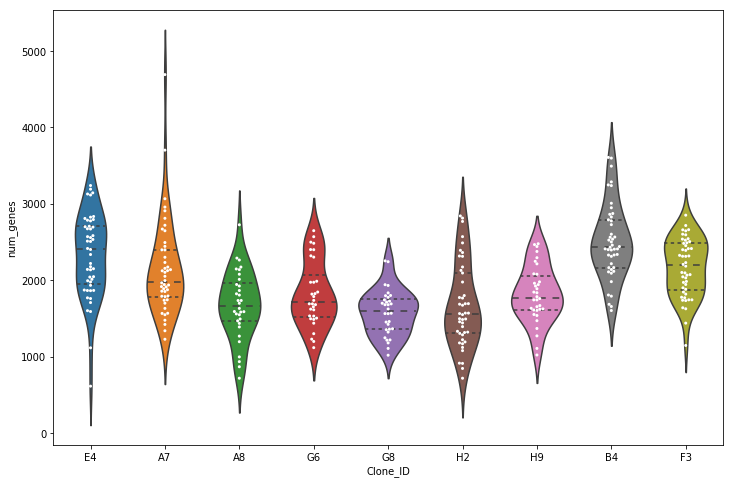

In [134]:
nG = nGene(EM_raw, meta_df)

Now we pick out the "good cells", whose expressed-gene-number is within two standard deviations of the mean (within each clone).

In [135]:
nG_std = nG.groupby('Clone_ID').apply(np.std)
nG_means = nG.groupby('Clone_ID').apply(np.mean)
nG_lowcut = (nG_means - 2*nG_std).num_genes
nG_highcut = (nG_means + 2*nG_std).num_genes
cells_good = [c for c in cells if 
              (nG.num_genes[c] >= nG_lowcut[nG.Clone_ID[c]]) and 
              (nG.num_genes[c] <= nG_highcut[nG.Clone_ID[c]]) 
             ]
print('{} cells remaining after {} poor libraries removed.'.format(len(cells_good), len(cells) - len(cells_good)))

345 cells remaining after 16 poor libraries removed.


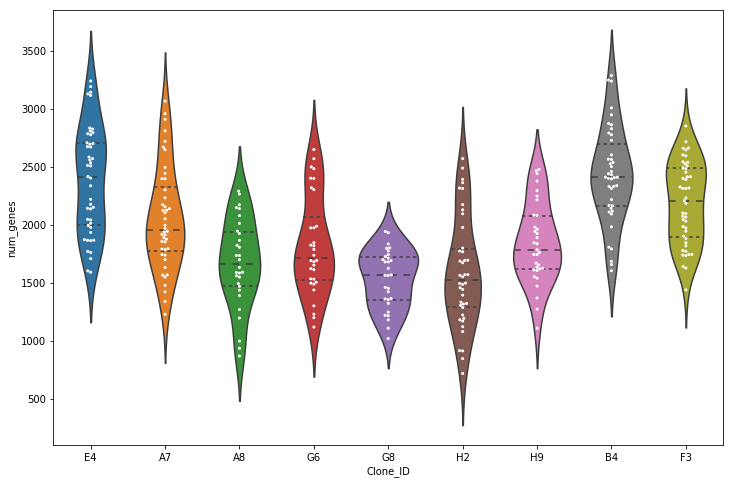

In [136]:
nG = nGene(EM_raw.loc[cells_good], meta_df.loc[cells_good]) # Post-trimming violin-plot.

We also look at the violin plots for the bulks, just to check on the numbers of expressed genes for each 50-cell bulk.

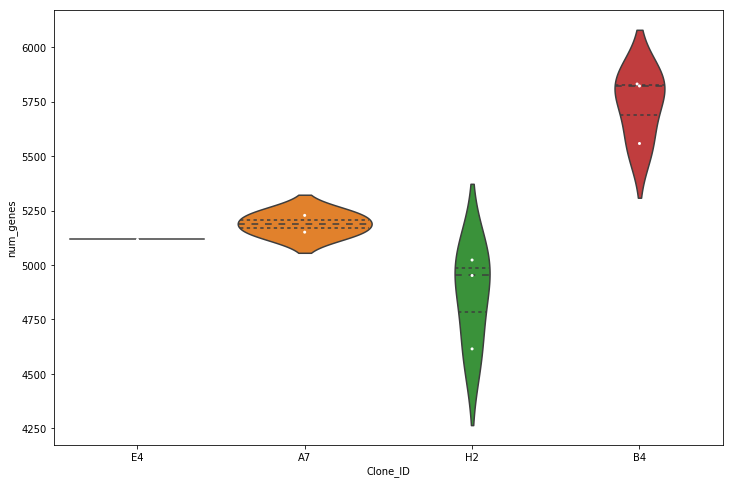

In [139]:
nG_bulks = nGene(EM_bulks_raw, meta_bulks) # Violin-plot for bulks

### Clipping and log-normalization

Now we normalize our gene expression matrix.  We only use the good cells (throwing out bad libraries) and relevant genes (as determined by the single cells).  We cut off all negative gene-expression, and normalize the gene expression on a log-scale.  In the end, a gene-expression value of $x$ will be replaced by $\log(1 + max(x,0))$ (natural logarithm).

In [140]:
EM_raw.head()

Geneid,WASH7P,CICP27,AL627309.1,RP11-34P13.14,RP11-34P13.13,RNU6-1100P,MTND1P23,MTND2P28,hsa-mir-6723,RP5-857K21.7,...,BCORP1,TXLNG2P,RP11-424G14.1,KDM5D,TTTY10,EIF1AY,RPS4Y2,TTTY5,PARP4P1,CTBP2P1
P1902_1289,17.409127,0.0,0.000000,0.0,3.904729,0.0,0.0,15.612185,2.640817,1.991584,...,0.0,0.0,0.0,0.000000,0.0,15.025001,0.0,0.0,0.0,0.0
P1902_1290,17.809043,0.0,0.000000,0.0,0.000000,0.0,0.0,49.764156,0.783038,3.543189,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
P1902_1291,0.000000,0.0,3.250691,0.0,0.000000,0.0,0.0,14.499668,7.941861,3.170853,...,0.0,0.0,0.0,0.000000,0.0,115.355768,0.0,0.0,0.0,0.0
P1902_1292,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,6.600071,22.328173,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
P1902_1293,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,17.604718,11.284506,2.836754,...,0.0,0.0,0.0,4.906722,0.0,0.000000,0.0,0.0,0.0,0.0


In [141]:
EM_bulks_raw.head()

Geneid,DDX11L1,WASH7P,MIR1302-10,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,RP11-34P13.8,CICP27,...,PPP1R12BP1,RNU6-1314P,CYCSP48,ANKRD36P1,TPTE2P4,CYCSP49,SLC25A15P1,PARP4P1,FAM58CP,CTBP2P1
P1902_1380,0.0,1.453124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
P1902_1382,0.0,0.744221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
P1902_1384,0.0,0.695663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15483,0.0,0.0
P1902_1570,0.0,1.678141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
P1902_1571,0.0,2.450329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [142]:
EM = EM_raw[genes_relevant].copy()  # Only use relevant genes.
EM = EM.loc[cells_good] # Only use good cells.
EM.clip(lower=0, inplace = True) # Clip any negative values to zero.
EM = EM.transform(np.log1p) # Apply log(1+x) transform.

EM_bulks = EM_bulks_raw[genes_relevant].copy()  # Only use relevant genes.
EM_bulks.clip(lower=0, inplace = True) # Clip any negative values to zero.
EM_bulks = EM_bulks.transform(np.log1p) # Apply log(1+x) transform.

## Examination of dropouts and suspicious genes for single cells

Now we examine the zeros (dropouts) and means in this matrix.  For each gene, we look at two quantities:  the *nonzero ratio* is the proportion of cells which express the gene (above the cutoff).  The *mean nonzero* is the mean of the (log-normalized) expression of the gene, restricting to the expressions above the cutoff.

The following function creates a dataframe with the nonzero ratio and mean nonzero value for every gene, using a given cutoff.  By default, the cutoff should be given in "absolute" terms, i.e., before log-normalization.  A cutoff of 10 seems reasonable.

In [143]:
def dropmean(df, cutoff, absolute=True):
    behave_df = df.copy()
    no_cells = len(behave_df)
    max_expression = behave_df.max()
    if absolute:
        co = np.log1p(cutoff)
    else:
        co = cutoff
    behave_df = behave_df.clip(co,max(max_expression))
    dropout_df = behave_df.apply(lambda column: ((column > co).sum()) / no_cells )
    meannz_df = behave_df.apply(lambda column: column.replace(co, np.nan).mean())
    dm_df = pd.concat([dropout_df, meannz_df], axis=1)
    dm_df = dm_df.rename(columns={0: "Nonzero Ratio", 1: "Mean nonzero"})
    return dm_df

To choose a reasonable cutoff, one can begin with a cutoff of zero, then increase the cutoff until the graph below loses the blob at the bottom right.  In other words, we should not find a clump of genes with very high nonzero ratio and low mean nonzero value.

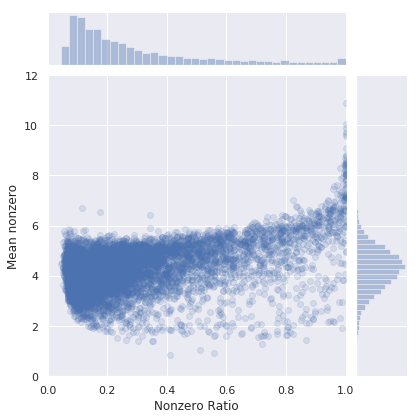

In [147]:
dm_df = dropmean(EM, 0) # Begin with cutoff at zero.
sns.set(style="darkgrid")
fig = sns.jointplot(x=dm_df['Nonzero Ratio'], y=dm_df['Mean nonzero'],
               alpha=.15, xlim=(0,1), ylim=(0,12), height=6)

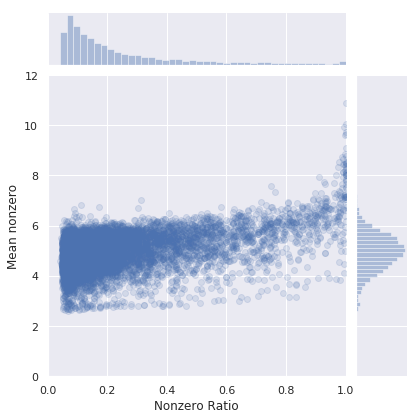

In [148]:
dm_df = dropmean(EM, 10) # Now impose a cutoff of 10.
sns.set(style="darkgrid")
fig = sns.jointplot(x=dm_df['Nonzero Ratio'], y=dm_df['Mean nonzero'],
               alpha=.15, xlim=(0,1), ylim=(0,12), height=6)

The 10-count cutoff effectively removed many suspicious genes on the bottom-right.  But still, the genes around the bottom right are a bit suspicious, and could be due to bad libraries.  The following labels genes as "suspect" if they lie in a rectangle with high nonzero-ratio and low mean-nonzero value.

In [149]:
def is_suspect(df, nzr_min = 0.95, mn_max = 5.5):
    '''
    Identifies genes as suspect if their nonzero ratio is above nzr_min
    and their mean nonzero expression (log1p-scaled) is below mn_max.
    The default mn_max 5.5 corresponds to a TPM count of 244.
    '''
    x = df['Nonzero Ratio']
    y = df['Mean nonzero']
    return ((x > nzr_min) & (y < mn_max))

In [150]:
suspect_mask = is_suspect(dm_df, 0.95, 5.5)
genes_suspect = list(suspect_mask[suspect_mask].index)
print('The following genes are suspected bad libraries: \n {}.'.format(', '.join(genes_suspect)))

The following genes are suspected bad libraries: 
 PFN1P1, MTA2, ARF6, CALR, HNRNPL, FTLP3, SON, CTNNB1, RP11-217O12.1, TMSB4XP4, MT-TC.


We highlight the suspect genes in red.

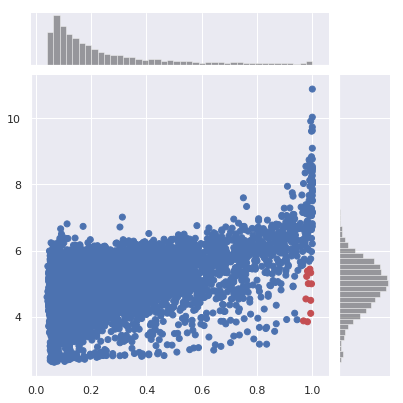

In [151]:
dm_df['color'] = 'b'
for gene in dm_df.index:
    if suspect_mask[gene]:
        dm_df.loc[gene,'color'] = 'r'
        
sns.set(style="darkgrid")
fig = sns.jointplot(x=dm_df['Nonzero Ratio'], y=dm_df['Mean nonzero'], color='k',
               alpha=.15, xlim=(0,1), ylim=(0,12), height=6)

fig.ax_joint.cla()
plt.sca(fig.ax_joint)
plt.scatter(dm_df['Nonzero Ratio'], dm_df['Mean nonzero'], c=dm_df['color'])
plt.show()

Now we drop the suspicious genes, and save our munged data.

In [152]:
EM = EM.drop(genes_suspect, axis=1) # Drop the suspect genes.
EM.to_pickle('P1902_EM.pkl') # Save file as a pickle.  This will be used for downstream analysis.
print('Expression matrix pickled, with shape {}'.format(EM.shape)) 

Expression matrix pickled, with shape (345, 7405)


In [154]:
EM_bulks = EM_bulks.drop(genes_suspect, axis=1) # Drop the suspect genes.
EM_bulks.to_pickle('P1902_EM_bulks.pkl') # Save file as a pickle.  This will be used for downstream analysis.
print('Expression matrix for bulks pickled, with shape {}'.format(EM_bulks.shape)) 

Expression matrix for bulks pickled, with shape (9, 7405)


## 3.  Quick shot at machine learning

After preprocessing the data, one might want to quickly check how well gene expression can predict clonotype.  The following steps will test out a linear support vector classifier. 

In [155]:
import statsmodels.api as sm

# Import various functions for stats.
from scipy.stats import f_oneway, binom, binom_test, kruskal, norm # For p-values, kruskal-wallis, Gaussian
from scipy.stats import kurtosis, skew # For detecting bimodality
from statsmodels.formula.api import ols

from bisect import bisect # See bisect.bisect.
from itertools import compress # I don't recall why this is here.

# Import from scikit, for machine learning.
# from sklearn import mixture  # Import Gaussian mixture

from sklearn.preprocessing import Binarizer, MinMaxScaler

from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV

from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.metrics import accuracy_score

from sklearn.svm import LinearSVC # Linear Support Vector Classifier 
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE


//anaconda/envs/Genomics/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [156]:
X = EM # Features are gene expressions.
X_cells = X.index
y = meta_df.loc[X_cells].Clone_ID # Can we predict clonality of cells?

Initialize a support vector machine classifier.  The pipeline begins with a min-max scaler (scaling all gene expressions to be between 0 and 1) and then selects the top $k$ genes based on ANOVA F statistics, and then applies a linear support vector classifier.

In [157]:
SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=100), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000))

The cross-validation will take a minute.  

In [158]:
# DANGER DANGER:  The following suppresses all warnings from Python.
# Otherwise, you'll probably get a bunch of convergence warnings...
# Alternatively, increase the number of iterations in the SVM.

import warnings
warnings.filterwarnings('ignore') # Ignore warnings.

param_grid = dict(linearsvc__C=[0.001, 0.01, 0.1, 1.0, 10, 100],
                  selectkbest__k = range(50,251,25),
                 )

grid_search = GridSearchCV(SVMpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=100, score_func=<function f_classif at 0x1a29af4f28>)), ('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'linearsvc__C': [0.001, 0.01, 0.1, 1.0, 10, 100], 'selectkbest__k': range(50, 251, 25)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The following function visualizes the result of cross-validation.

In [165]:
def CV_map(gs, swap=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with {0:}-fold cross-validation. \n"
                 "Best score {1:2.1%} with parameters \n"
                 "{2} ".format(gs.cv, gs.best_score_, gs.best_params_))

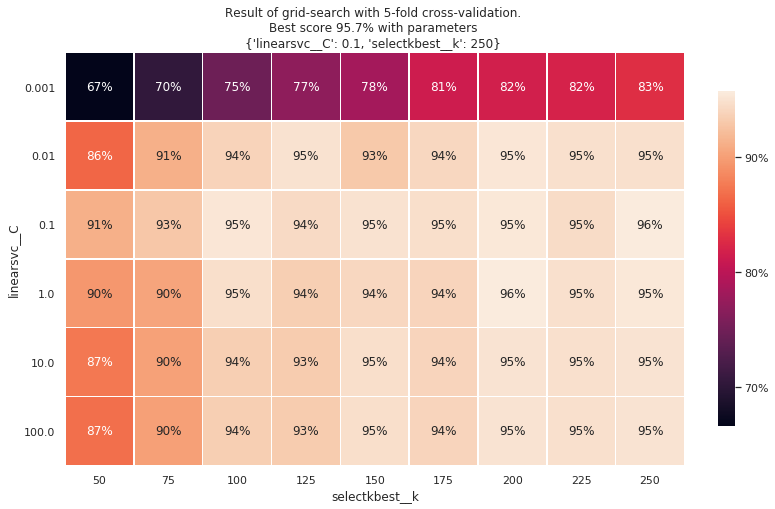

In [166]:
CV_map(grid_search)

The following plots a "confusion matrix" to see how cells belonging to one clone are classified correctly or incorrectly to another clone.

In [167]:
from sklearn import base

def confusion_matrix(X,y,pipe, reps=2, classlist = None):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    valid = counts.apply(lambda column : column/cpops['pop']) #['pop'] )
    
    f, ax = plt.subplots(figsize=(len(classes)+1,len(classes)))
    sns.heatmap(valid, annot=valid, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.046, 'pad':0.04}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25, .5, .75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_ylabel("Actual class")
    ax.set_xlabel("Predicted class")
    ax.set_title("Overall prediction accuracy {:0.3%}. \n"
                 "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))

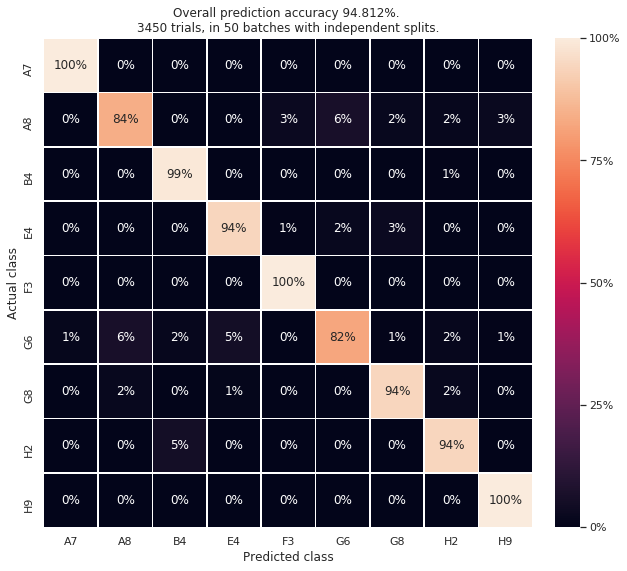

In [168]:
opt_k = grid_search.best_params_['selectkbest__k'] # Use optimal number of genes.
opt_C = grid_search.best_params_['linearsvc__C'] # Use optimal C-parameter for linear SVM.

SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=opt_k), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000, C=opt_C))

confusion_matrix(X,y,SVMpipe, reps=50, classlist = clones)